# Real Data Seismogram Simulation
For this simulation, we will utilize real earthquake data that we obtain from the USGS library and the Vp, Vs, and Density model from the IASP91 and CRUST 1.0 library. 

IASP91 is a standard ID Earth velocity model, where it describes average Vp and Vs based on the depth of the Earth. It assumes that Earth's Vp and Vs only vary within depth, not with the location.

Meanwhile, CRUST 1.0 is a model files that can be used to obtain more realistic crustal velocity and density model based on the latitude and longitude (location specific). But, it is more accurate only until ~50 km of the crustal structure. So, we decided to combine IASP91 with CRUST1.0 for better visualization purpose.

In [2]:
from libcomcat.dataframes import (get_detail_data_frame, get_dyfi_data_frame,
                                  get_history_data_frame, get_magnitude_data_frame,
                                  get_pager_data_frame, get_phase_dataframe,
                                  get_summary_data_frame)
from libcomcat.search import search, get_event_by_id
from datetime import datetime
import netCDF4 as nc
import numpy as np
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt

In [3]:
# Get summary of earthquake events based on the USGS library
summary_events = search(starttime=datetime(1994, 1, 17, 12, 30), endtime=datetime(1994, 1, 17, 12, 35),)
summary_df = get_summary_data_frame(summary_events)
summary_df

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,ci3144585,1994-01-17 12:30:55.390000+00:00,"Northridge, California, earthquake",34.213,-118.537,18.202,6.70,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1561
1,ci3145042,1994-01-17 12:30:55.850000+00:00,"1km NW of Northridge, California",34.240,-118.541,20.322,3.55,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,194
2,ci3149646,1994-01-17 12:31:58.120000+00:00,"1km ENE of Granada Hills, California",34.275,-118.493,5.317,5.89,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,534
3,ci3144587,1994-01-17 12:32:54.530000+00:00,"7km S of Santa Clarita, California",34.351,-118.500,9.317,3.27,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,165
4,ci2153163,1994-01-17 12:33:50.830000+00:00,"6km SE of Santa Clarita, California",34.377,-118.467,5.285,3.56,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,195
5,ci3144599,1994-01-17 12:34:18.420000+00:00,"4km NW of Pacoima, California",34.308,-118.475,5.487,4.44,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,303


In [4]:
# The CRUST1.0 model
vp_dataset = nc.Dataset('CRUST1.0-vp.r0.1.nc')
vs_dataset = nc.Dataset('CRUST1.0-vs.r0.1.nc')
rho_dataset = nc.Dataset('CRUST1.0-rho.r0.1.nc')

# location
choice = 0
latitude = summary_df['latitude'][choice]
longitude = summary_df['longitude'][choice]
if longitude < 0:
    longitude += 360

latitudes = vp_dataset.variables['latitude'][:]
longitudes = vp_dataset.variables['longitude'][:]
lat_idx = np.abs(latitudes - latitude).argmin()
lon_idx = np.abs(longitudes - longitude).argmin()

In [5]:
# layers and average thickness
layers = [
    ("water_vp", "water_vs", "water_rho", 3000),
    ("ice_vp", "ice_vs", "ice_rho", 2000),
    ("upper_sediments_vp", "upper_sediments_vs", "upper_sediments_rho", 2000),
    ("middle_sediments_vp", "middle_sediments_vs", "middle_sediments_rho", 3000),
    ("lower_sediments_vp", "lower_sediments_vs", "lower_sediments_rho", 5000),
    ("upper_crust_vp", "upper_crust_vs", "upper_crust_rho", 10000),
    ("middle_crust_vp", "middle_crust_vs", "middle_crust_rho", 15000),
    ("lower_crust_vp", "lower_crust_vs", "lower_crust_rho", 20000)
]

t_max = 0.1

In [6]:
crust_depths = []
crust_vp = []
crust_vs = []
crust_rho = []

depth = 0  
for vp_layer, vs_layer, rho_layer, thickness in layers:
    vp = vp_dataset.variables.get(vp_layer, None)
    vs = vs_dataset.variables.get(vs_layer, None)
    rho = rho_dataset.variables.get(rho_layer, None)

    # convert to m/s for vp and vs and to kg/m^3 for rho
    vp_val = float(vp[lat_idx, lon_idx]) * 1000 if vp is not None else np.nan
    vs_val = float(vs[lat_idx, lon_idx]) * 1000 if vs is not None else np.nan
    rho_val = float(rho[lat_idx, lon_idx]) * 1000 if rho is not None else np.nan

    crust_depths.append(depth)
    crust_vp.append(vp_val)
    crust_vs.append(vs_val)
    crust_rho.append(rho_val)

    depth += thickness

crust_depths = np.array(crust_depths)
crust_vp = np.array(crust_vp)
crust_vs = np.array(crust_vs)
crust_rho = np.array(crust_rho)

### The Gardner's Equation
The Gardner's Equation is a derived equation that relates the seismic P-wave velocity (Vp) with the density of the medium which the wave travels. The equation is as below.
$$
\rho = \alpha V_p^{\beta}
$$
where $\rho$ is the density in $g/cm^3$, $\alpha$ and $\beta$ are constants that depends on the geology. Gardner et al. proposed that a good fit can be obtained if we use $\alpha = 0.31$ and $\beta = 0.25$ if $V_p$ in $m/s$.

In [7]:
# The IASP91 model
model = TauPyModel("iasp91")
iasp_depths = []
iasp_vp = []
iasp_vs = []
iasp_rho = []  

for layer in model.model.s_mod.v_mod.layers:
    d = layer[0] * 1000
    if d <= crust_depths[-1]:
        continue  # skip shallow layers

    iasp_depths.append(d)
    iasp_vp.append(layer[2] * 1000)
    iasp_vs.append(layer[3] * 1000)

    # Rough density estimate via Gardner's Equation
    rho_est = 0.31 * ((layer[2] * 1000) ** (0.25))  
    iasp_rho.append(rho_est * 1000)

iasp_depths = np.array(iasp_depths)
iasp_vp = np.array(iasp_vp)
iasp_vs = np.array(iasp_vs)
iasp_rho = np.array(iasp_rho)

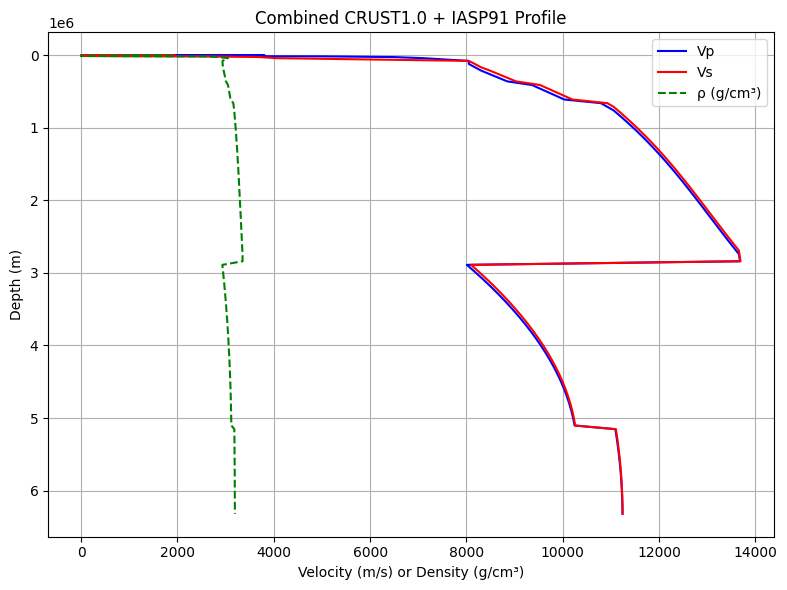

In [8]:
depth_combined = np.concatenate([crust_depths, iasp_depths])
vp_combined = np.concatenate([crust_vp, iasp_vp])
vs_combined = np.concatenate([crust_vs, iasp_vs])
rho_combined = np.concatenate([crust_rho, iasp_rho])

# -----------------------------
# 4. Plot result
# -----------------------------
plt.figure(figsize=(8, 6))
plt.plot(vp_combined, depth_combined, label='Vp', color='blue')
plt.plot(vs_combined, depth_combined, label='Vs', color='red')
plt.plot(rho_combined, depth_combined, label='ρ (g/cm³)', color='green', linestyle='--')

plt.gca().invert_yaxis()
plt.xlabel('Velocity (m/s) or Density (g/cm³)')
plt.ylabel('Depth (m)')
plt.title('Combined CRUST1.0 + IASP91 Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# calculate x and y based on latitude and longitude
from geopy.distance import geodesic
from math import cos

NX, NY = 200, 400
XMIN, XMAX = 0.0, 2000.0
YMIN, YMAX = 0.0, 4000.0
DX = (XMAX - XMIN) / NX
DY = (YMAX - YMIN) / NY

# 1 degree latitude ≈ 111 km (constant)
# 1 degree longitude ≈ 111 km × cos(latitude)
epicenter = (latitude, longitude)
deg_per_meter_lat = 1 / 111000 
deg_per_meter_lon = 1 / (111000 * cos(latitude)) 
origin_lat = epicenter[0] - (YMAX / 2) * deg_per_meter_lat
origin_lon = epicenter[1]- (XMAX / 2) * deg_per_meter_lon

y_meters = geodesic((origin_lat, origin_lon), (epicenter[0], origin_lon)).meters
x_meters = geodesic((origin_lat, origin_lon), (origin_lat, epicenter[1])).meters

# Convert to grid index
source_y = int(y_meters / DY)
source_x = int(x_meters / DX)
print(f'source_x: {source_x}, source_y: {source_y}')


source_x: 88, source_y: 199


In [10]:
# --- Velocity Model ---
from scipy.interpolate import interp1d

# Interpolate real velocity and density data to match NY grid size
depth_target = np.linspace(0, YMAX, NY)  # in meters

vp_interp = interp1d(depth_combined, vp_combined, bounds_error=False, fill_value="extrapolate")
vs_interp = interp1d(depth_combined, vs_combined, bounds_error=False, fill_value="extrapolate")
rho_interp = interp1d(depth_combined, rho_combined, bounds_error=False, fill_value="extrapolate")

vp_profile = vp_interp(depth_target)
vs_profile = vs_interp(depth_target)
rho_profile = rho_interp(depth_target)

# Assign to full grid
VEL_P = np.tile(vp_profile, (NX, 1))
VEL_S = np.tile(vs_profile, (NX, 1))
RHO = np.tile(rho_profile, (NX, 1))

vp_profile = VEL_P[source_x, :]
vs_profile = VEL_S[source_x, :]
rho_profile = RHO[source_x, :]

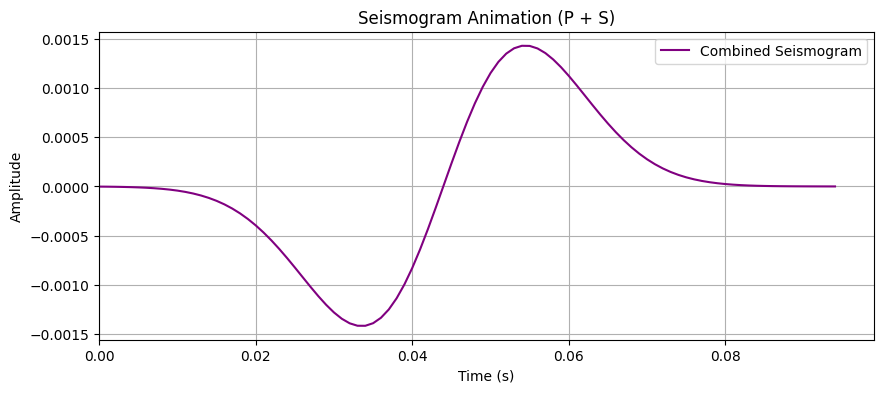

In [11]:
# Seismogram
import sys
import os
sys.path.append(os.path.abspath('../GUI'))

from seismogram import Seismogram


# Combined P-wave and S-wave Seismogram
window = Seismogram(NX, NY, XMIN, XMAX, t_max, VEL_P, VEL_S, RHO, "real",source_x)
window.compute()
window.create_combined_figure()


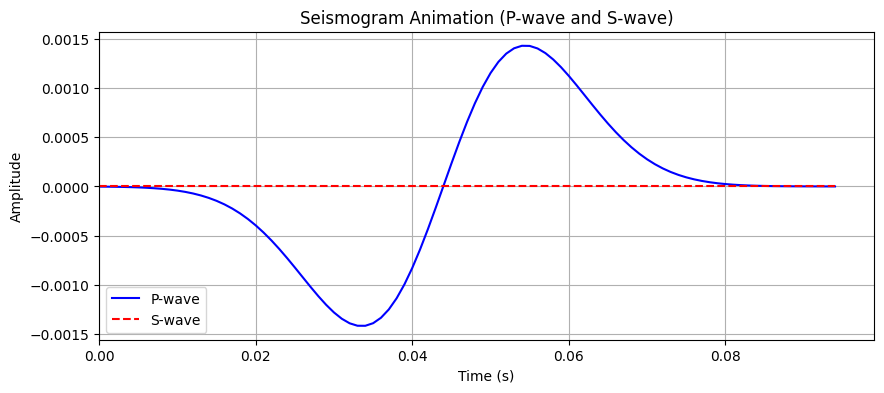

In [12]:
# Separated P-wave and S-wave Seismogram

window = Seismogram(NX, NY, XMIN, XMAX, t_max, VEL_P, VEL_S,RHO, "real",source_x)
window.compute()
window.create_separated_figure()

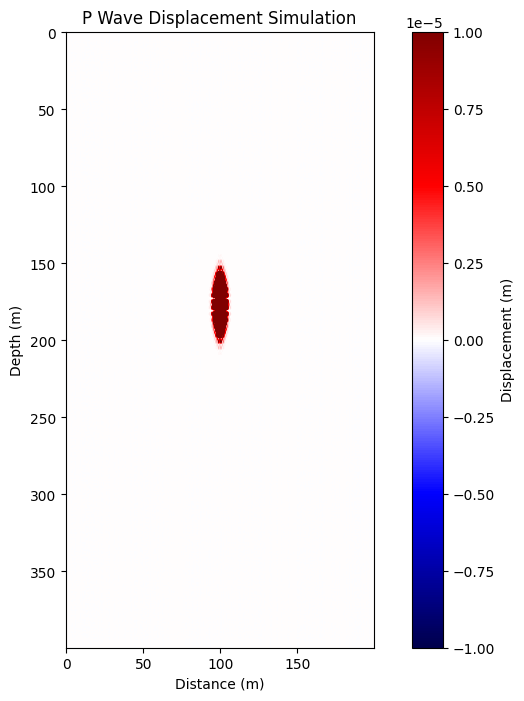

In [13]:
# P-wave Displacement

from P_wave_disp import PWaveDisplacement

window = PWaveDisplacement(NX, NY, XMIN, XMAX, t_max, VEL_P, RHO, "real",source_x, source_y)
window.run_wavelet_eq()
window.create_figure()

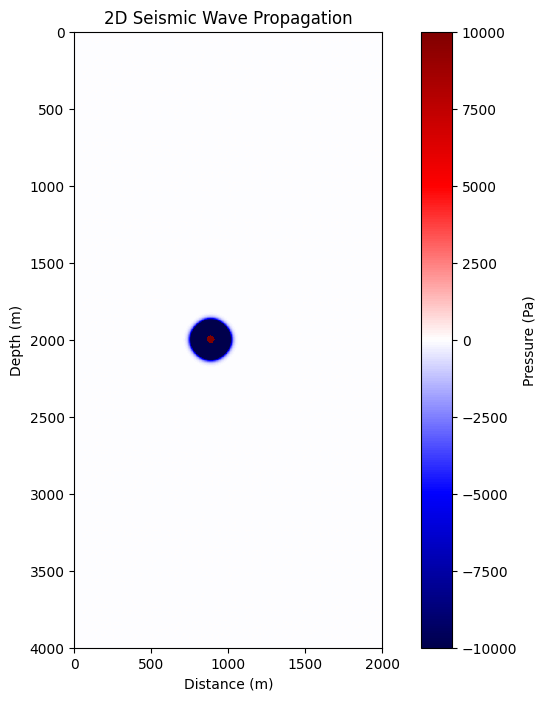

In [14]:
# P Wave Pressure

from P_wave_pressure import PWavePressure

window = PWavePressure(NX, NY, XMIN, XMAX, YMIN, YMAX, t_max, VEL_P, RHO, "real",source_x, source_y)
window.run_wavelet_eq()
window.create_figure()

Seismic moment = 112784751070.61067 
Magnitude = 17.011228421524045 
Energy Released= 5.447144885708699e+29


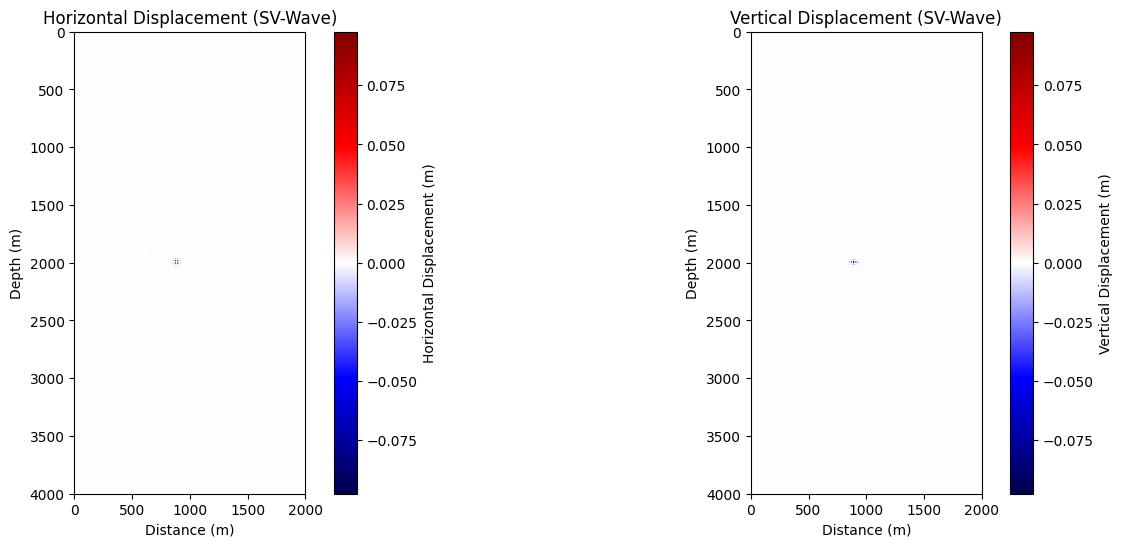

In [ ]:
# S Wave Displacement

from S_wave import SWave

window = SWave(NX, NY, XMIN, XMAX, YMIN, YMAX, t_max, VEL_S,RHO, "real",source_x, source_y)
window.run_wavelet_eq()
window.create_figure_displacement()


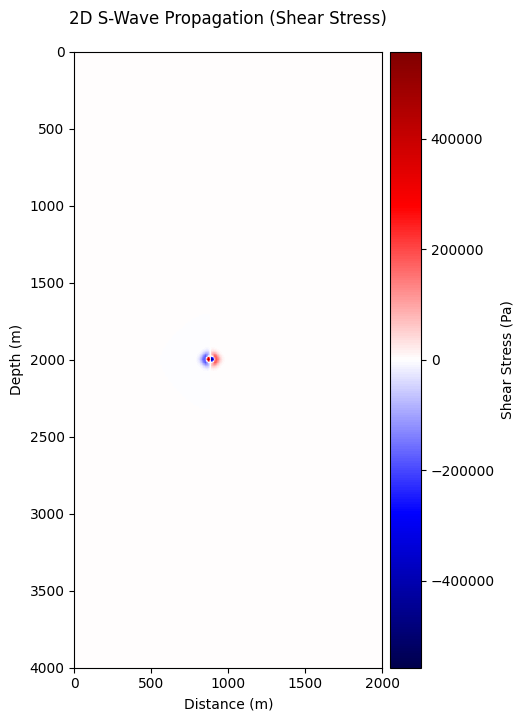

In [16]:
window = SWave(NX, NY, XMIN, XMAX, YMIN, YMAX, t_max, VEL_S, RHO, "real",source_x, source_y)
window.run_wavelet_eq()
window.create_figure_stress()